In [1]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import math as m
import numpy as np
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
sns.set(font_scale = 2.5)
plt.rcParams['figure.figsize'] = (12, 9)

In [2]:
def growth_rate_to_doubling_time(growth_rates):
    return np.sign(growth_rates) * (np.log(2) / (np.sign(growth_rates) * growth_rates))

def doubling_time_to_growth_rate(doubling_times):
    return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))

In [3]:
data = pd.read_excel("Data/Simulation Results/UK Model/backwards tracing pars frozen recall high app.xlsx", index_col = 0)
days_simulated = 25

In [4]:
data

hazard_rate_scale  infection_reporting_prob  \
0              0.23767                       0.3   
1              0.23767                       0.3   
2              0.23767                       0.3   
3              0.23767                       0.3   
4              0.23767                       0.3   
..                 ...                       ...   
995            0.23767                       0.3   
996            0.23767                       0.3   
997            0.23767                       0.3   
998            0.23767                       0.3   
999            0.23767                       0.3   

     contact_tracing_success_prob  contact_trace_delay_par  \
0                             0.8                        2   
1                             0.8                        2   
2                             0.8                        2   
3                             0.8                        2   
4                             0.8                        2   
..                            ...                      ...   
995                           0.8                        2   
996                           0.8                        2   
997                           0.8                        2   
998                           0.8                        2   
999                           0.8                        2   

     global_contact_reduction  prob_has_trace_app  \
0                         0.3                 0.5   
1                         0.3                 0.5   
2                         0.3                 0.5   
3                         0.3                 0.5   
4                         0.3                 0.5   
..                        ...                 ...   
995                       0.3                 0.5   
996                       0.3                 0.5   
997                       0.3                 0.5   
998                       0.3                 0.5   
999                       0.3                 0.5   

     test_before_propagate_tracing  test_delay_mean  \
0                             True             1.52   
1                             True             1.52   
2                             True             1.52   
3                             True             1.52   
4                             True             1.52   
..                             ...              ...   
995                           True             1.52   
996                           True             1.52   
997                           True             1.52   
998                           True             1.52   
999                           True             1.52   

     probable_infections_need_test  number_of_days_to_trace_backwards  ...  \
0                            False                                 12  ...   
1                            False                                 14  ...   
2                            False                                 11  ...   
3                            False                                  3  ...   
4                            False                                  9  ...   
..                             ...                                ...  ...   
995                          False                                  6  ...   
996                          False                                 11  ...   
997                          False                                 12  ...   
998                          False                                  9  ...   
999                          False                                  5  ...   

       15    16    17    18    19    20    21    22    23    24  
0    1257  1448  1674  1940  2239  2584  2927  3344  3803  4355  
1    1098  1263  1453  1680  1903  2142  2457  2798  3177  3557  
2     979  1121  1288  1455  1625  1849  2066  2337  2609  2914  
3    1244  1448  1673  1895  2200  2515  2872  3286  3763  4307  
4     992  1136  1308  1478  1702  1933  2171  2485  2828  3200  
..  

In [5]:
infection_counts = [str(i) for i in range(days_simulated)]
infection_counts = data[infection_counts]

Text(0.5, 1.0, 'Total Infected')

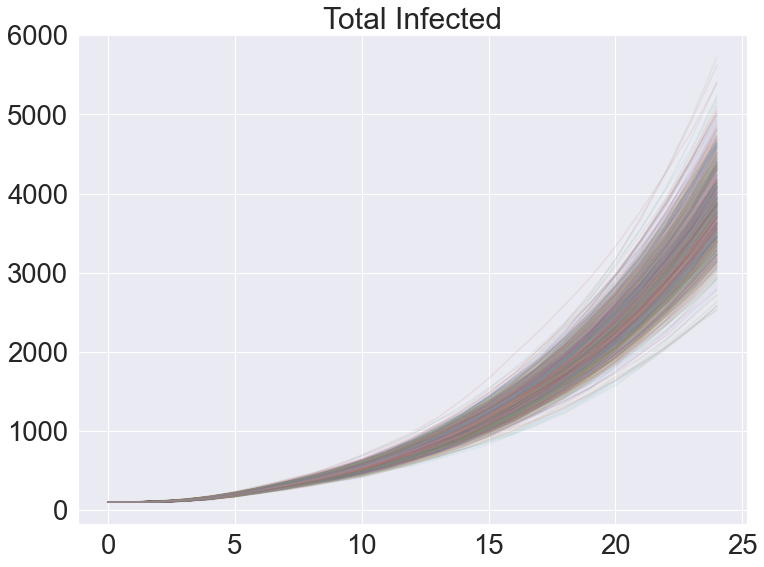

In [6]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_], alpha = 0.1)
plt.title("Total Infected")

Text(0.5, 1.0, '$log_2$(Total Infected)')

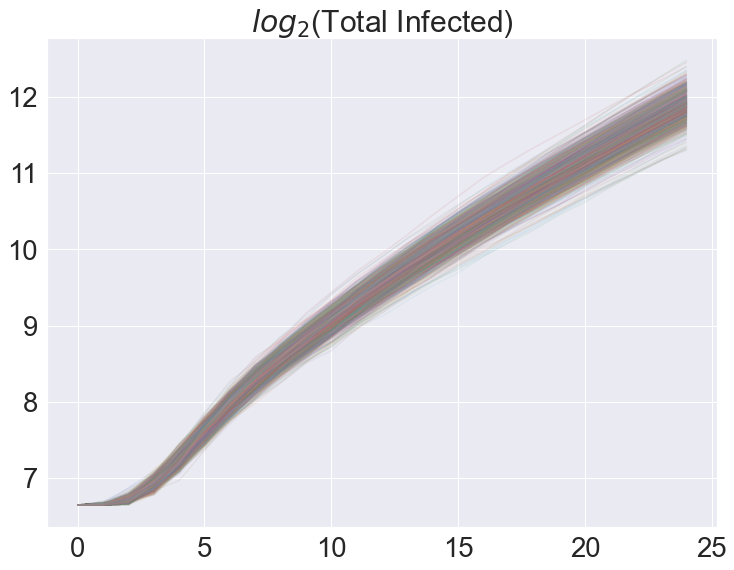

In [7]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].apply(lambda x: np.log2(x)), alpha = 0.1)
plt.title("$log_2$(Total Infected)")

Text(0.5, 1.0, 'Infection Incidence')

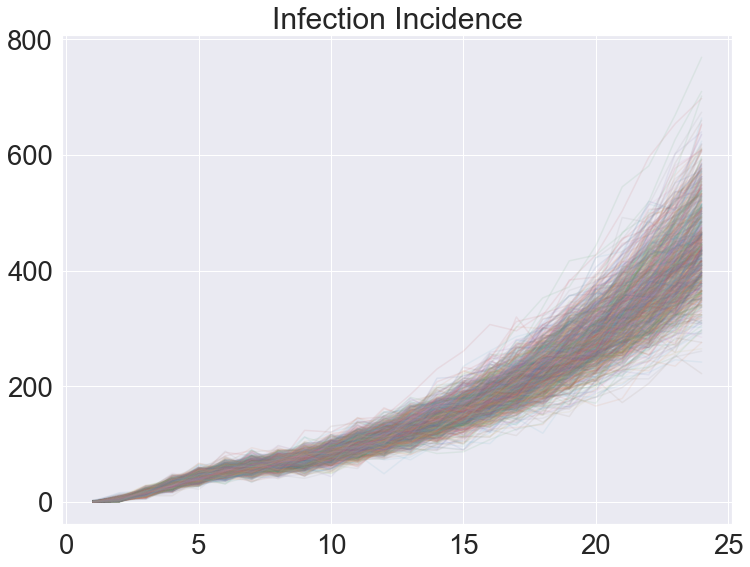

In [8]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.1)
plt.title("Infection Incidence")

Text(0.5, 1.0, 'Infection Incidence (10 epidemics)')

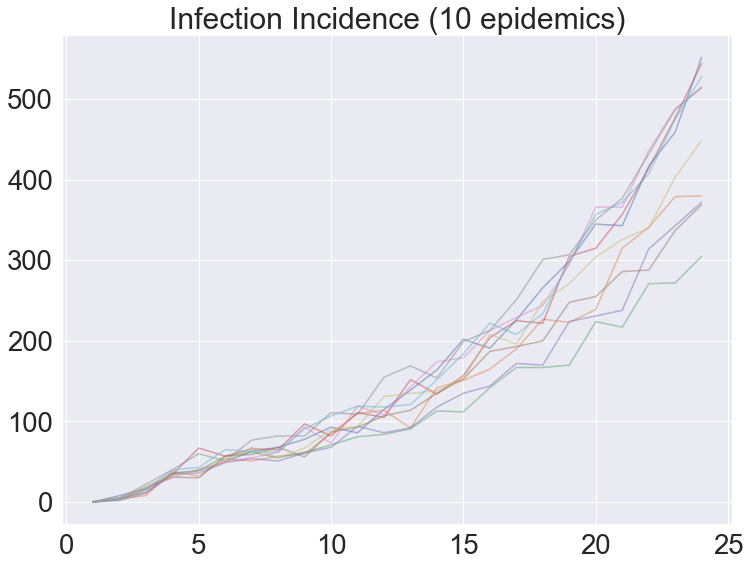

In [9]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.5)
plt.title("Infection Incidence (10 epidemics)")

Text(0.5, 1.0, '$Log_e$(Case Incidence) (14 epidemics)')

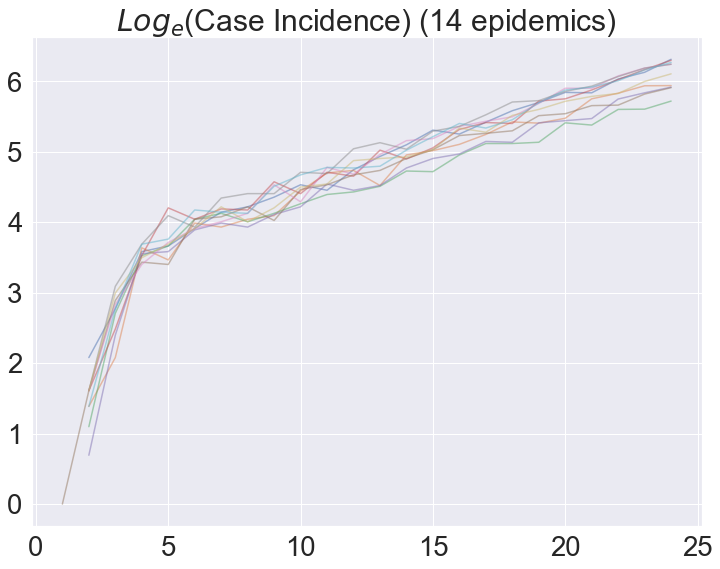

In [10]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x)), alpha = 0.5)
plt.title("$Log_e$(Case Incidence) (14 epidemics)")
#plt.savefig("Figures/Log_case_incidence.png")

We can see the variance begins to increase for the exponentially decaying epidemcis as they near 0. In order to get good estimation for the epidemics, we icnrease the starting number of infections. In this experiment, we start with 5000 infected, let the process run for 10 days, and then estimated the growth rate using days 10-30.

In [11]:
log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

data_set_up = {
    "log_case_incidence": log_diff[10:days_simulated],
    "time": list(range(10, days_simulated))
}
dataframe = pd.DataFrame(data_set_up)

                            OLS Regression Results                            
Dep. Variable:     log_case_incidence   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     690.0
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           1.19e-12
Time:                        12:11:55   Log-Likelihood:                 18.295
No. Observations:                  15   AIC:                            -32.59
Df Residuals:                      13   BIC:                            -31.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3773      0.080     41.973      0.0

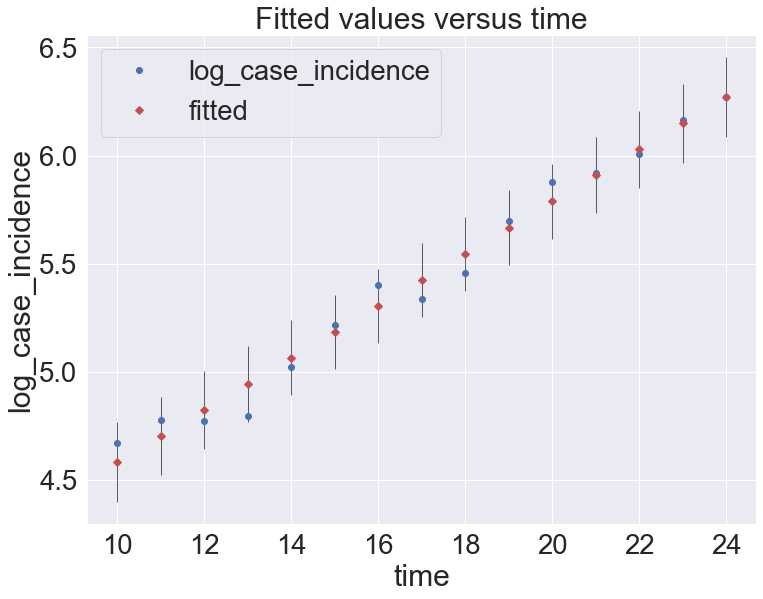

In [12]:
y, X = dmatrices('log_case_incidence ~ time', 
                 data = dataframe)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig = sm.graphics.regressionplots.plot_fit(res, 1)
print(f"doublign time = {m.log(2)/res.params[1]}")

In [13]:
data_subset = infection_counts

In [14]:
growth_rates = []
for _ in range(data_subset.shape[0]):
    print(f"current fit; {_}", end = "\r")
    
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    data_set_up = {
        "log_case_incidence": log_diff[10:25],
        "time": list(range(10, 25))
    }
    dataframe = pd.DataFrame(data_set_up)
    dataframe = pd.DataFrame(data_set_up)
    
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

In [15]:
x = pd.Series(growth_rates) # 200 values
#x = x[x.between(x.quantile(.05), x.quantile(.95))] # without outliers

Text(0.5, 1.0, 'Distribution of Growth Rates')

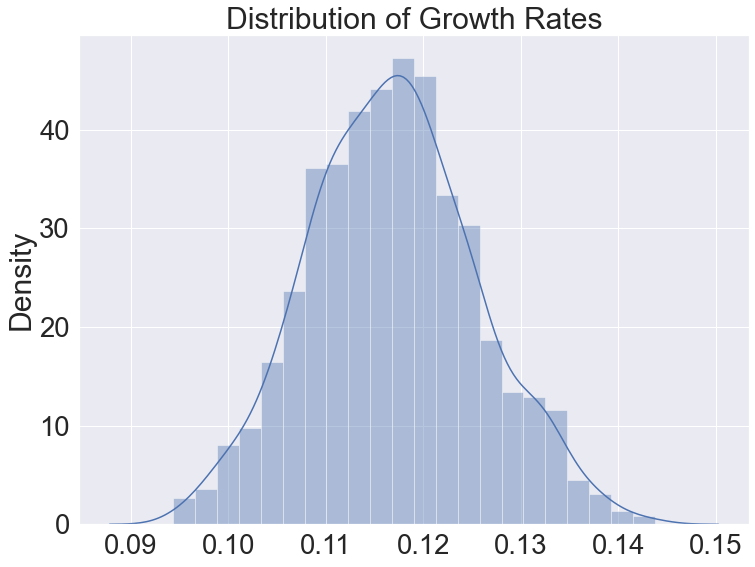

In [16]:
sns.distplot(x)
plt.title("Distribution of Growth Rates")

In [17]:
data_pars = data[data.columns[0:11]]
growth_rate_series = pd.Series(growth_rates)
data_pars["growth_rate"] = growth_rate_series

In [18]:
data_pars

hazard_rate_scale  infection_reporting_prob  \
0              0.23767                       0.3   
1              0.23767                       0.3   
2              0.23767                       0.3   
3              0.23767                       0.3   
4              0.23767                       0.3   
..                 ...                       ...   
995            0.23767                       0.3   
996            0.23767                       0.3   
997            0.23767                       0.3   
998            0.23767                       0.3   
999            0.23767                       0.3   

     contact_tracing_success_prob  contact_trace_delay_par  \
0                             0.8                        2   
1                             0.8                        2   
2                             0.8                        2   
3                             0.8                        2   
4                             0.8                        2   
..                            ...                      ...   
995                           0.8                        2   
996                           0.8                        2   
997                           0.8                        2   
998                           0.8                        2   
999                           0.8                        2   

     global_contact_reduction  prob_has_trace_app  \
0                         0.3                 0.5   
1                         0.3                 0.5   
2                         0.3                 0.5   
3                         0.3                 0.5   
4                         0.3                 0.5   
..                        ...                 ...   
995                       0.3                 0.5   
996                       0.3                 0.5   
997                       0.3                 0.5   
998                       0.3                 0.5   
999                       0.3                 0.5   

     test_before_propagate_tracing  test_delay_mean  \
0                             True             1.52   
1                             True             1.52   
2                             True             1.52   
3                             True             1.52   
4                             True             1.52   
..                             ...              ...   
995                           True             1.52   
996                           True             1.52   
997                           True             1.52   
998                           True             1.52   
999                           True             1.52   

     probable_infections_need_test  number_of_days_to_trace_backwards  \
0                            False                                 12   
1                            False                                 14   
2                            False                                 11   
3                            False                                  3   
4                            False                                  9   
..                             ...                                ...   
995                          False                                  6   
996                          False                                 11   
997                          False                                 12   
998                          False                                  9   
999                          False                                  5   

     backwards_tracing_time_limit  growth_rate  
0                              21     0.126069  
1                              21     0.107931  
2                              21     0.106621  
3                              21     0.130004  
4                              21     0.119871  
..                            ...          ...  
995                            21     0.123807  
996                            21     0.124258  
997                

In [19]:
y, X = dmatrices('growth_rate ~ number_of_days_to_trace_backwards + number_of_days_to_trace_backwards**2', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     348.4
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           6.24e-67
Time:                        12:12:06   Log-Likelihood:                 3479.5
No. Observations:                1000   AIC:                            -6955.
Df Residuals:                     998   BIC:                            -6945.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [20]:
y, X = dmatrices('growth_rate ~  number_of_days_to_trace_backwards + I(number_of_days_to_trace_backwards**2)', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     284.7
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           1.51e-98
Time:                        12:12:06   Log-Likelihood:                 3555.7
No. Observations:                1000   AIC:                            -7105.
Df Residuals:                     997   BIC:                            -7091.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Text(0, 0.5, 'Halving / doubling times (days)')

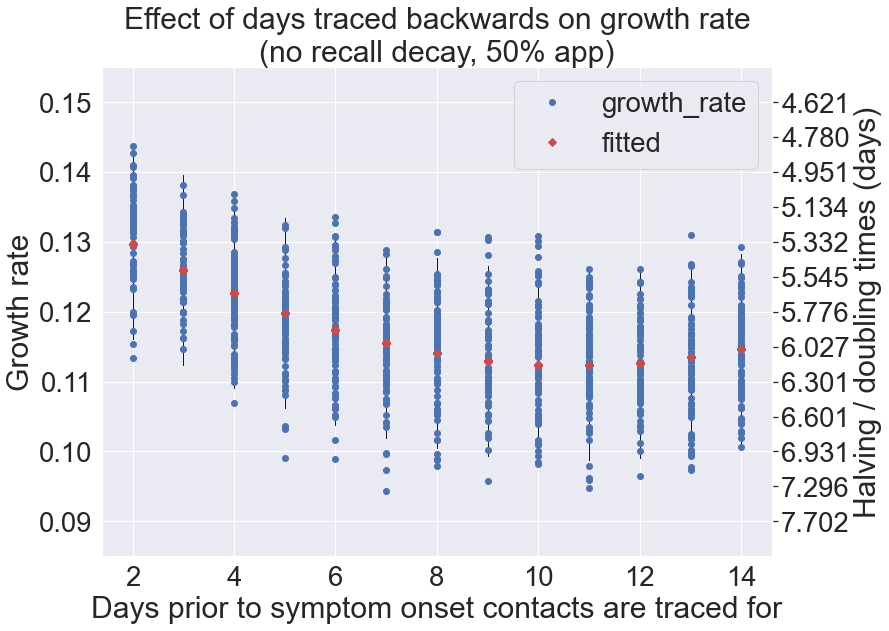

In [23]:
fig, ax = plt.subplots()

sm.graphics.regressionplots.plot_fit(res, "number_of_days_to_trace_backwards", ax = ax)

y_vals = np.linspace(0.15, 0.09, 13)
ax2 = ax.secondary_yaxis("right", functions=(growth_rate_to_doubling_time, doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.ylim(0.085, 0.155)

plt.title("Effect of days traced backwards on growth rate\n(no recall decay, 50% app)")
plt.xlabel("Days prior to symptom onset contacts are traced for")
plt.ylabel("Growth rate")

ax2.set_ylabel("Halving / doubling times (days)")
#plt.savefig("../../Figures/UK Model/days_prior_to_symptom_onset_recall_high_app.png", bbox_inches = 'tight')
#plt.savefig("../../Figures/UK Model/days_prior_to_symptom_onset_recall_high_app.svg", bbox_inches = 'tight')


## Residuals vs Fitted Value

There doesn't appear to be any systematic deviation from our predicted value

Text(0, 0.5, 'Residual')

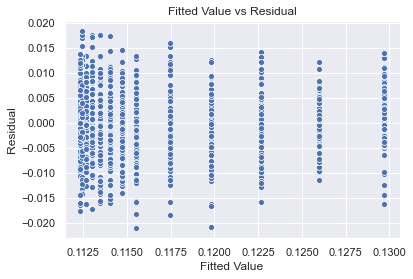

In [22]:
sns.scatterplot(res.fittedvalues, res.resid)
plt.title("Fitted Value vs Residual")
plt.xlabel("Fitted Value")
plt.ylabel("Residual")

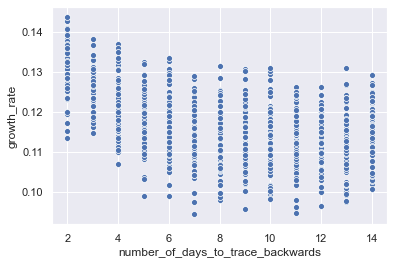

In [23]:
sns.scatterplot(data_pars["number_of_days_to_trace_backwards"], data_pars["growth_rate"])

## Residual Distribution

Text(0.5, 1.0, 'Distribution of the residuals')

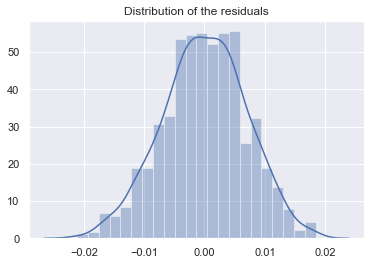

In [24]:
sns.distplot(res.resid)
plt.title("Distribution of the residuals")

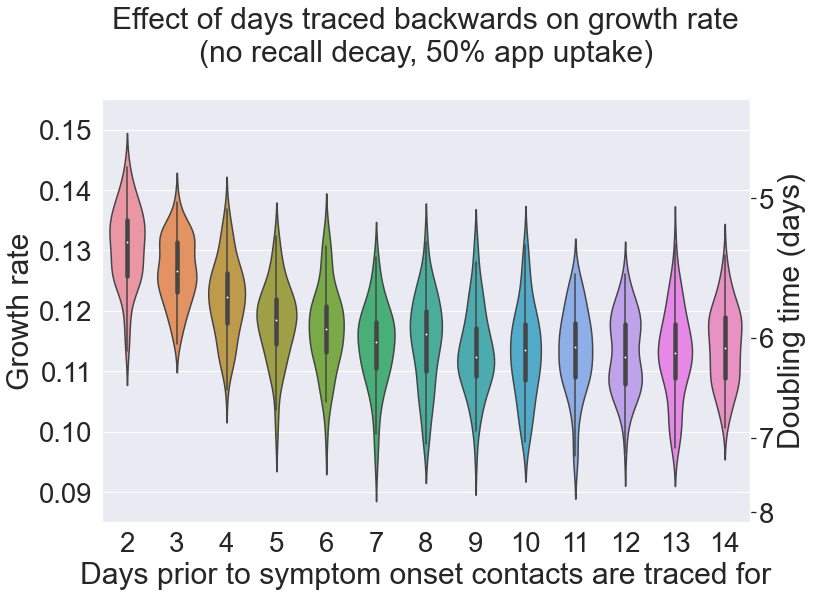

In [26]:
fig, ax = plt.subplots()

growth_rate_outputs = data_pars[['number_of_days_to_trace_backwards', 'growth_rate']]
sns.violinplot(x = 'number_of_days_to_trace_backwards', y = 'growth_rate', data = growth_rate_outputs, ax = ax)

y_vals = [doubling_time_to_growth_rate(x) for x in [4, 5, 6, 7, 8]]

ax2 = ax.secondary_yaxis("right", functions=(growth_rate_to_doubling_time, doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.ylim(0.085, 0.155)
ax2.set_ylabel("Doubling time (days)")
plt.title("Effect of days traced backwards on growth rate\n(no recall decay, 50% app uptake)\n")
plt.xlabel("Days prior to symptom onset contacts are traced for")
plt.ylabel("Growth rate")


plt.tight_layout()
plt.savefig("Figures/UK Model/violin_plot_days_prior_to_symptom_onset_high_app.png")
plt.savefig("Figures/UK Model/violin_plot_days_prior_to_symptom_onset_high_app.pdf")
plt.savefig("Figures/UK Model/violin_plot_days_prior_to_symptom_onset_high_app.jpg")